Specify code parameters.

In [1]:
user = 'elias'  # 'chris' or 'elias'
embedding_type = 'tf-idf'  # 'tf' or 'tf-idf'
is_debug = False
K = 1000  # number of principal components

In [2]:
if user == 'elias':
    project_dir = 'C:/Users/Elias/Documents/DME/'
    data_dir = 'C:/Users/Elias/Documents/DME/data/'
elif user == 'chris':
    project_dir = '/Users/sipola/Google Drive/education/coursework/graduate/edinburgh/dme/project'
    data_dir = '/Users/sipola/Desktop/v2-all_in_one'
else:
    raise ValueError('Give valid user')

Import everything else.

In [3]:
import os
os.chdir(project_dir)  # to import scripts

import os
import numpy as np
import re
import time
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scripts import *

%matplotlib inline

os.chdir(data_dir)  # since we'll be pulling everything from here

In [4]:
# Read labels in first so know which histids to keep when reading tfdf data.
y_full, keys_labels = read_transform_labels('labels/en.useful-labels.csv')
# print y_full.head()
# print keys_labels

In [5]:
# Create dictionary with {hostid: sparse vector}. There are something like 60,000 rows in the full data set (unless subsetting for hostids.).
t0 = time.time()
tfdf_filename = 'features/tfdf/v2-host_tfdf_en.txt' if user == 'elias' else 'features/tfdf/v2-host_tfdf.en.txt'
sparse = create_sparse_embeddings(tfdf_filename,
                                  hostids=y_full['ID'].tolist(),
                                  embedding_type=embedding_type)
print_run_time(t0)

run time: 0.89 min


In [6]:
if is_debug:
    # Look at entry for one hostid.
    print 'num rows in data: {}'.format(len(tf_idf_sparse))
    print 15*'='
    print 'first row:\nhostid: {}\nwordids and tf-idf values: {}'.format(tf_idf_sparse.keys()[0], tf_idf_sparse.values()[0])

In [7]:
# Convert to DataFrame.
X = pd.DataFrame.from_dict(sparse, orient='index')  # convert to DataFrame

if embedding_type == 'tf-idf':
    
    min_val = min(X.min())  # get min of entire matrix
    if is_debug:
        print 'minimum value: {}'.format(min_val)
    X = X - min_val  # make so lowest value is zero

X = X.fillna(0)  # fill NaNs with zeros

if is_debug:
    X  # show X

In [8]:
if is_debug:
    print X.shape

In [9]:
hostids = X.index.values  # save for later

In [10]:
X_scaled = StandardScaler().fit_transform(X)  # is this how you do this??????

In [286]:
# Fit PCA incrementally (otherwise there are memory issues)
# http://stackoverflow.com/a/32191686
t0 = time.time()
ipca = IncrementalPCA()
X_fit = ipca.fit_transform(X_scaled)
print_run_time(t0)

run time: 0.72 min


In [289]:
if is_debug:
    sns.distplot(X_fit.ix[:,1])
    print np.std(X_fit)
    print X_fit.shape

In [290]:
X_fit = pd.DataFrame(X_fit)
X_fit['ID'] = hostids
if is_debug:
    X_fit

In [291]:
X_full = pd.merge(y_full, X_fit, on='ID')

In [292]:
# y_full.ix[y_full.loc[:,'ID'] == 88495]

In [293]:
# X_full.ix[X_full.duplicated(subset='ID', keep=False)]
if is_debug:
    print 'numer of rows: {}'.format(X_full.shape)
X_full = X_full.drop_duplicates(subset='ID')
if is_debug:
    print 'numer of rows: {}'.format(X_full.shape)

In [294]:
# if is_debug:
#     # Why are there now more rows? Duplicates in label data?
#     print 'num IDs in full but not in fit: {}'.format(sum([x not in X_fit['ID'].tolist() for x in X_full['ID'].tolist()]))  # 0
#     print 'num IDs in labels: {}'.format(len(y_full['ID'].tolist()))
#     print 'num *unique* IDs in labels: {}'.format(len(set(y_full['ID'].tolist())))

#     # Answer: yes, duplicates in label data.

In [295]:
X_train_keys = X_fit.keys().drop('ID')

In [296]:
if is_debug:
    print keys_labels

In [297]:
def get_train_valid_data(X_full, label, X_train_keys, is_debug=False):
    
    # Remove rows with bad target data.
    if is_debug:
        print 'dropping {} out of {} rows for bad {} data...'.format(sum(X_full.loc[:,label] == 0), X_full.shape[0], label)
    X_ = X_full.ix[X_full.loc[:,label] != 0]
    
    # Add y column (binary: 0, 1).
    X_['y'] = [int(x) for x in X_.loc[:,label] == 1]
    
    # Drop unneeded columns.
    keep_col_bool = [c in X_train_keys or c=='y' for c in X_.columns]
    X_ = X_.loc[:, keep_col_bool]
    
    # Split into test and validation.
    # http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    X_train, X_valid, y_train, y_valid = train_test_split(X_[X_train_keys], X_['y'],stratify=X_['y'])
    
    return X_train, X_valid, y_train, y_valid

# get_train_valid_data(X_full, labels[0], X_train_keys)[0]

In [298]:

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import confusion_matrix

labels = ['News/Editorial', 'Commercial', 'Educational/Research', 'Discussion', 'Personal/Leisure', 'Media']
models_dict = {'dummy': DummyClassifier(),
               'logistic regression': LogisticRegression(),
               'naive Bayes': GaussianNB(),
               'forest': RandomForestClassifier(),
               'MLP': None  #MLPClassifier()  # needs K, so defined in K loop
              }
K_to_use = [1, 2, 3, 4, 5, 7, 10, 25, 100, 250, 1000, 1307]

stats = {}

for label in labels:
    
    print '\n=====\nlabel: {}\n====='.format(label)
    label_stats = {}

    X_train_label, X_valid_label, y_train, y_valid = get_train_valid_data(X_full, label, X_train_keys)
    
    for model_name, model in models_dict.iteritems():

        print 'model: {}'.format(model_name)
        model_stats = {}

        for kk in K_to_use:

            K_stats = {}
            
            if model_name == 'MLP':
                model = MLPClassifier(hidden_layer_sizes=(kk, np.ceil(np.sqrt(kk)),))

            # print '\trunning k={}...'.format(kk)
            # print model
            
            X_train = X_train_label.loc[:, range(kk)]
            X_valid = X_valid_label.loc[:, range(kk)]

            fit = model.fit(X_train, y_train)

            K_stats['acc(train)'] = fit.score(X_train, y_train)
            K_stats['acc(valid)'] = fit.score(X_valid, y_valid)
            K_stats['f1(train)'] = f1_score(y_train, fit.predict(X_train))
            K_stats['f1(valid)'] = f1_score(y_valid, fit.predict(X_valid))
            K_stats['prec(train)'] = precision_score(y_train, fit.predict(X_train))
            K_stats['prec(valid)'] = precision_score(y_valid, fit.predict(X_valid))
            K_stats['rec(train)'] = recall_score(y_train, fit.predict(X_train))
            K_stats['rec(valid)'] = recall_score(y_valid, fit.predict(X_valid))
            K_stats['cm(train)'] = confusion_matrix(y_train, fit.predict(X_train))
            K_stats['cm(valid)'] = confusion_matrix(y_valid, fit.predict(X_valid))
            
            model_stats[kk] = K_stats

        label_stats[model_name] = model_stats
        
    stats[label] = label_stats


=====
label: News/Editorial
=====


C:\Users\Elias\AppData\Local\conda\conda\envs\python2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


model: dummy
model: MLP
model: naive Bayes
model: forest
model: logistic regression

=====
label: Commercial
=====
model: dummy
model: MLP
model: naive Bayes
model: forest
model: logistic regression

=====
label: Educational/Research
=====
model: dummy
model: MLP
model: naive Bayes
model: forest
model: logistic regression

=====
label: Discussion
=====
model: dummy
model: MLP
model: naive Bayes
model: forest
model: logistic regression

=====
label: Personal/Leisure
=====
model: dummy
model: MLP
model: naive Bayes
model: forest
model: logistic regression

=====
label: Media
=====
model: dummy
model: MLP
model: naive Bayes
model: forest
model: logistic regression


In [299]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn-whitegrid')
sns.set_palette("Set2")
    
kfs = {'acc':'Accuracy','f1':'F1 Score','prec':'Precision','rec':'Recall'}

def plot_acc_f1(self,show=False):
    fig = plt.figure(figsize=(10,10))
    plt.title('{} - {}'.format(self.model,self.label))
    for i,kf in enumerate(kfs):
        ax = plt.subplot(len(kfs),1,i+1)
        plt.plot(self.loc['{kf}(train)'.format(kf=kf)],label='Training')
        plt.plot(self.loc['{kf}(valid)'.format(kf=kf)],label='Validation')
        plt.xlim(min(K_to_use),max(K_to_use))
        plt.xscale('log')
        plt.ylabel(kfs[kf])
        ax.xaxis.set_ticks(K_to_use)
        ax.xaxis.set_ticklabels(K_to_use)
        plt.legend()
    fig.savefig('../plots/acc_f1_{}_{}.png'.format(self.model,self.label.replace('/','-')))
    if show: plt.show()

def plot_pr_curve(self,show=False):
    fig = plt.figure(figsize=(5,5)) 
    plt.scatter(self.loc['prec(train)'],self.loc['rec(train)'],label='Training')
    plt.scatter(self.loc['prec(valid)'],self.loc['rec(valid)'],label='Validation')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend()
    fig.savefig('../plots/pr_{}_{}.png'.format(self.model,self.label.replace('/','-')))
    if show: plt.show()

def plot_cm(self,show=False,kk_list=K_to_use,modes=['train','valid']):
    for mode in modes:
        s = math.ceil(math.sqrt(len(kk_list)))
        fig = plt.figure(figsize=(s*4,s*4))
        #plt.title('{} - {}'.format(self.model,self.label))
        if len(kk_list)==1:
            kk = kk_list[0]
            ax = sns.heatmap(self.loc['cm({})'.format(mode)][kk],annot=True,fmt='d',square=True,
                             xticklabels=['Predict: no','Predict: yes'],yticklabels=['Actual: no','Actual: yes'])
            #plt.xlabel('Prediction')
            #plt.ylabel('True label')
            plt.title(self.label)
            ax.get_figure().savefig('../plots/cm_{}_{}_{}_k{}.png'.format(self.model,self.label.replace('/','-'),mode,kk))
        else:
            for i,kk in enumerate(kk_list):
                ax = plt.subplot(math.ceil(math.sqrt(len(kk_list))),math.floor(math.sqrt(len(kk_list))),i+1)
                ax.set_title('k = {}'.format(kk))
                sns.heatmap(self.loc['cm({})'.format(mode)][kk],annot=True,fmt='d',square=True)
            fig.savefig('../plots/cm_{}_{}_{}.png'.format(self.model,self.label.replace('/','-'),mode))
        if show: plt.show()
    
    
pd.DataFrame.plot_acc_f1 = plot_acc_f1
pd.DataFrame.plot_pr_curve = plot_pr_curve
pd.DataFrame.plot_cm = plot_cm

for label in labels:
    for model in models_dict:
        stats[label][model] = pd.DataFrame(stats[label][model])
        stats[label][model].label = label
        stats[label][model].model = model

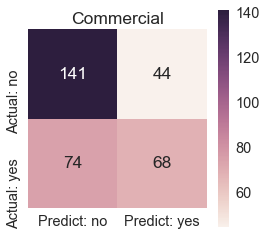

In [300]:
stats['Commercial']['forest'].plot_cm(kk_list=[100],modes=['valid'])

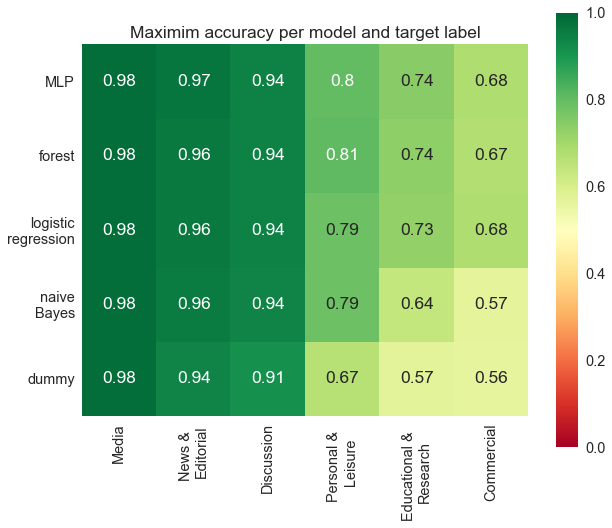

,Media,News/Editorial,Discussion,Personal/Leisure,Educational/Research,Commercial
MLP,0.984709,0.972477,0.944954,0.804281,0.743119,0.681957
forest,0.984709,0.963303,0.944954,0.807339,0.737003,0.672783
logistic regression,0.984709,0.963303,0.941896,0.785933,0.727829,0.681957
naive Bayes,0.984709,0.957187,0.938838,0.785933,0.642202,0.568807
dummy,0.984709,0.938838,0.911315,0.666667,0.571865,0.562691


In [368]:
sns.set(font_scale=1.45)

flat = {}
for label in labels:
    flat[label] = {}
    for model in models_dict:
        flat[label][model] = stats[label][model].loc['acc(valid)'].max()
flat = pd.DataFrame(flat)

flat['mean'] = flat.mean(axis=1)
flat = flat.sort_values('mean',ascending=False).T
flat['mean'] = flat.mean(axis=1)
flat = flat.sort_values('mean',ascending=False).T
flat = flat.drop('mean',axis=0).drop('mean',axis=1)

fig = plt.figure(figsize=(10,8))
ax = sns.heatmap(flat,cmap='RdYlGn',annot=True, vmax=1, vmin=0,square=True)
ax.xaxis.set_ticklabels([l.get_text().replace('/',' &  \n') for l in ax.xaxis.get_ticklabels()])
ax.yaxis.set_ticklabels([l.get_text().replace(' ','\n') for l in ax.yaxis.get_ticklabels()])
plt.title('Maximim accuracy per model and target label')
fig.savefig('../plots/acc_valid_max.png')
plt.show()
flat

In [369]:
flat.mean()

Media                   0.984709
News/Editorial          0.959021
Discussion              0.936391
Personal/Leisure        0.770031
Educational/Research    0.684404
Commercial              0.633639
dtype: float64

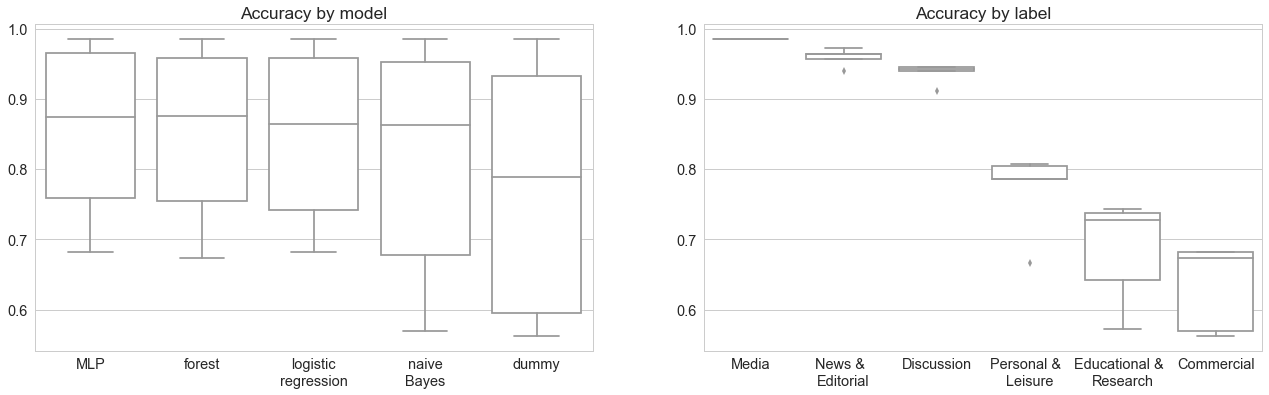

In [370]:
style.use('seaborn-whitegrid')
sns.set_palette("Set2")

plt.figure(figsize=(22,6))

plt.subplot(1,2,1)

ax = sns.boxplot(flat.T,color='white')
ax.xaxis.set_ticklabels([l.get_text().replace(' ','\n') for l in ax.xaxis.get_ticklabels()])
ax.set_title('Accuracy by model')


plt.subplot(1,2,2)

ax = sns.boxplot(flat,color='white')
ax.xaxis.set_ticklabels([l.get_text().replace('/',' &  \n') for l in ax.xaxis.get_ticklabels()])
ax.set_title('Accuracy by label')

ax.get_figure().savefig('../plots/acc_model.png')
plt.show()

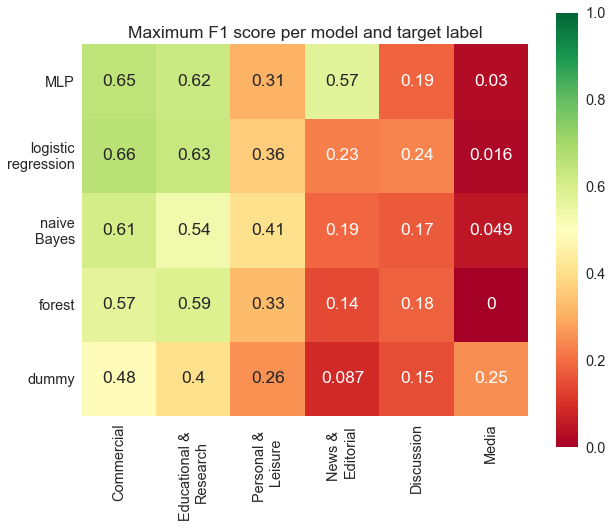

,Commercial,Educational/Research,Personal/Leisure,News/Editorial,Discussion,Media
MLP,0.653333,0.625000,0.309091,0.571429,0.186047,0.030120
logistic regression,0.662338,0.634921,0.359788,0.229508,0.238095,0.016393
naive Bayes,0.607889,0.535211,0.405145,0.190476,0.168421,0.048780
forest,0.570281,0.586538,0.326923,0.142857,0.181818,0.000000
dummy,0.484429,0.403292,0.255319,0.086957,0.150000,0.250000


In [371]:
flat = {}
for label in labels:
    flat[label] = {}
    for model in models_dict:
        flat[label][model] = stats[label][model].loc['f1(valid)'].max()
flat = pd.DataFrame(flat)

flat['mean'] = flat.mean(axis=1)
flat = flat.sort_values('mean',ascending=False).T
flat['mean'] = flat.mean(axis=1)
flat = flat.sort_values('mean',ascending=False).T
flat = flat.drop('mean',axis=0).drop('mean',axis=1)

fig = plt.figure(figsize=(10,8))
ax = sns.heatmap(flat,cmap='RdYlGn',annot=True,vmax=1, vmin=0,square=True)
ax.xaxis.set_ticklabels([l.get_text().replace('/',' &  \n') for l in ax.xaxis.get_ticklabels()])
ax.yaxis.set_ticklabels([l.get_text().replace(' ','\n') for l in ax.yaxis.get_ticklabels()])
plt.title('Maximum F1 score per model and target label')
fig.savefig('../plots/f1_valid_max.png')
plt.show()
flat

In [388]:
stats['Discussion']['naive Bayes']

,1,2,3,4,5,7,10,25,100,250,1000,1307
acc(train),0.941837,0.928571,0.92449,0.939796,0.937755,0.933673,0.922449,0.92449,0.897959,0.297959,0.691837,0.791837
acc(valid),0.938838,0.938838,0.938838,0.938838,0.938838,0.93578,0.926606,0.914373,0.892966,0.229358,0.66055,0.75841
cm(train),"[[923, 2], [55, 0]]","[[904, 21], [49, 6]]","[[900, 25], [49, 6]]","[[914, 11], [48, 7]]","[[912, 13], [48, 7]]","[[908, 17], [48, 7]]","[[897, 28], [48, 7]]","[[898, 27], [47, 8]]","[[868, 57], [43, 12]]","[[244, 681], [7, 48]]","[[627, 298], [4, 51]]","[[724, 201], [3, 52]]"
cm(valid),"[[307, 1], [19, 0]]","[[306, 2], [18, 1]]","[[306, 2], [18, 1]]","[[306, 2], [18, 1]]","[[306, 2], [18, 1]]","[[305, 3], [18, 1]]","[[302, 6], [18, 1]]","[[298, 10], [18, 1]]","[[290, 18], [17, 2]]","[[61, 247], [5, 14]]","[[207, 101], [10, 9]]","[[240, 68], [11, 8]]"
f1(train),0,0.146341,0.139535,0.191781,0.186667,0.177215,0.155556,0.177778,0.193548,0.122449,0.252475,0.337662
f1(valid),0,0.0909091,0.0909091,0.0909091,0.0909091,0.0869565,0.0769231,0.0666667,0.102564,0.1,0.139535,0.168421
prec(train),0,0.222222,0.193548,0.388889,0.35,0.291667,0.2,0.228571,0.173913,0.0658436,0.146132,0.205534
prec(valid),0,0.333333,0.333333,0.333333,0.333333,0.25,0.142857,0.0909091,0.1,0.0536398,0.0818182,0.105263
rec(train),0,0.109091,0.109091,0.127273,0.127273,0.127273,0.127273,0.145455,0.218182,0.872727,0.927273,0.945455
rec(valid),0,0.0526316,0.0526316,0.0526316,0.0526316,0.0526316,0.0526316,0.0526316,0.105263,0.736842,0.473684,0.421053


In [373]:
flat.mean()

Commercial              0.595654
Educational/Research    0.556993
Personal/Leisure        0.331253
News/Editorial          0.244245
Discussion              0.184876
Media                   0.069059
dtype: float64

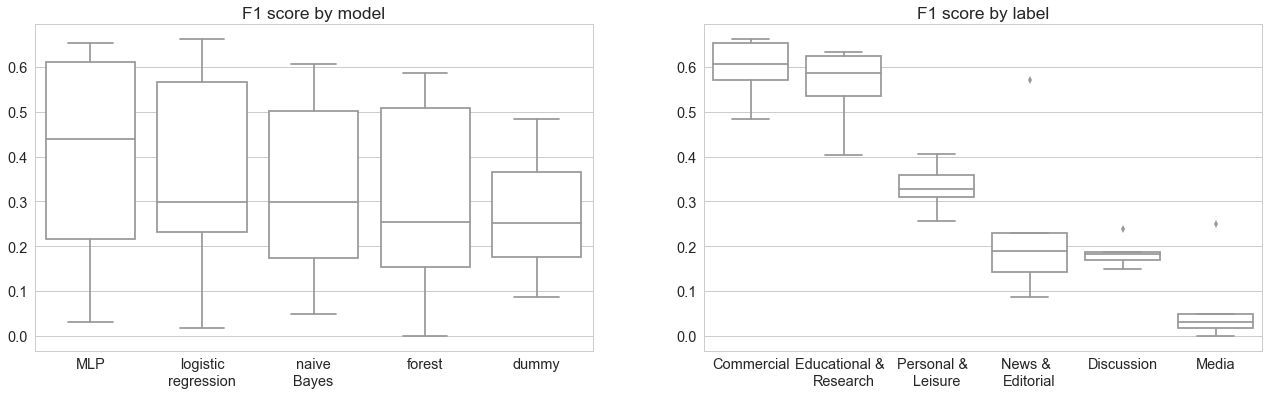

In [384]:
plt.figure(figsize=(22,6))

plt.subplot(1,2,1)

ax = sns.boxplot(flat.T,color='white')
ax.xaxis.set_ticklabels([l.get_text().replace(' ','\n') for l in ax.xaxis.get_ticklabels()])
ax.set_title('F1 score by model')


plt.subplot(1,2,2)

ax = sns.boxplot(flat,color='white')
ax.xaxis.set_ticklabels([l.get_text().replace('/',' &  \n') for l in ax.xaxis.get_ticklabels()])
ax.set_title('F1 score by label')

ax.get_figure().savefig('../plots/f1_model.png')
plt.show()

In [390]:
flat.T.describe()

,MLP,logistic regression,naive Bayes,forest,dummy
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.395837,0.356841,0.325987,0.301403,0.271666
std,0.258820,0.251747,0.223402,0.238550,0.149834
min,0.030120,0.016393,0.048780,0.000000,0.086957
25%,0.216808,0.231655,0.173935,0.152597,0.175000
50%,0.440260,0.298942,0.297810,0.254371,0.252660
75%,0.611607,0.566138,0.502695,0.509442,0.366299
max,0.653333,0.662338,0.607889,0.586538,0.484429


Using matplotlib backend: Qt5Agg

News/Editorial		MLP 
Commercial		MLP 
Educational/Research		MLP 
Discussion		MLP 
Personal/Leisure		MLP 
Media		MLP


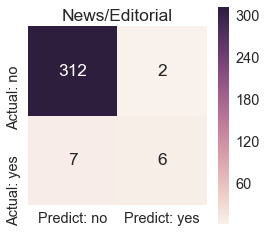

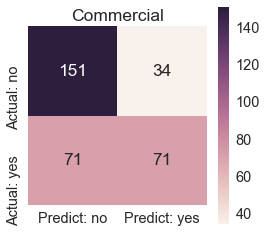

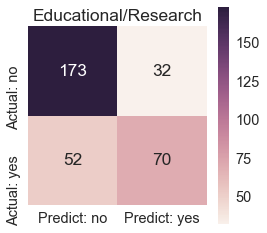

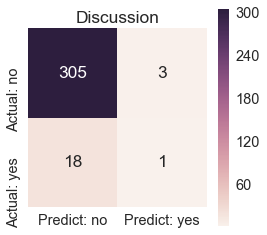

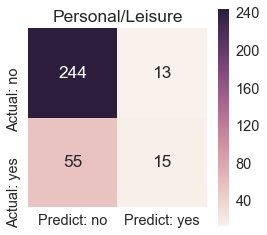

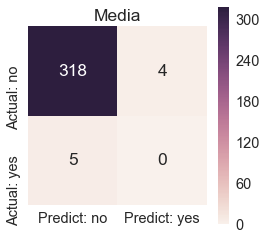

In [303]:
for label in labels:
    print '\n{}\t'.format(label),
    for model in ['MLP']: # models_dict:
        print '\t{}'.format(model),
        #stats[label][model].plot_pr_curve()
        #stats[label][model].plot_cm(modes=['valid'])
        stats[label][model].plot_cm(kk_list=[100],modes=['valid'])
        #stats[label][model].plot_acc_f1()

In [ ]:
stats['Commercial']['forest']

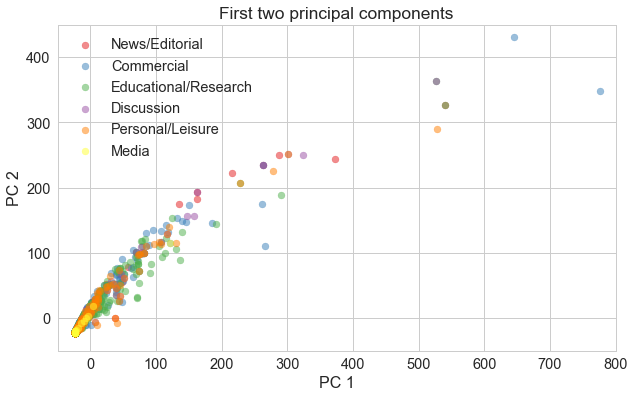

In [322]:
style.use('seaborn-whitegrid')
sns.set_palette("Set1")

sub = False

fig = plt.figure(figsize=(10,36 if sub else 6))
for i,l in enumerate(labels):
    if sub: plt.subplot(6,1,i+1)
    Xf = X_full[X_full[l]==1]
    plt.scatter(Xf[0],Xf[1],label=l,alpha=0.5)
    plt.xlim(-50,800)
    plt.ylim(-50,450)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('First two principal components')
    plt.legend()
fig.savefig('../plots/2d.png')

In [304]:
out = X_full[labels]

In [305]:
counts = {
    'yes': out[out==1].count(),
    'n/a': out[out==0].count(),
    'no': out[out==-1].count()
}
counts = pd.DataFrame(counts)
counts['total'] = (counts['yes'] + counts['no'])
counts['yes %'] = counts['yes'] / counts['total']
counts['no %'] = counts['no'] / counts['total']
counts['label'] = counts.index
counts.sort_values('yes',ascending=False,inplace=True)
counts

,n/a,no,yes,total,yes %,no %,label
Commercial,44,739,568,1307,0.434583,0.565417,Commercial
Educational/Research,44,818,489,1307,0.374139,0.625861,Educational/Research
Personal/Leisure,44,1026,281,1307,0.214996,0.785004,Personal/Leisure
Discussion,44,1233,74,1307,0.056618,0.943382,Discussion
News/Editorial,44,1257,50,1307,0.038256,0.961744,News/Editorial
Media,44,1288,19,1307,0.014537,0.985463,Media


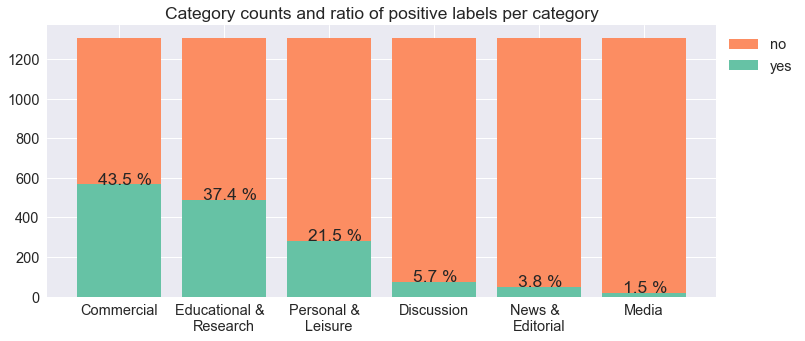

In [308]:
#sns.barplot(data=counts,x='label',y='no')
#sns.barplot(data=counts,x='label',y='yes')
sns.set_palette("Set2")

fig = plt.figure(figsize=(12,5))
plt.bar(range(6),counts['total'],label='no',color=sns.color_palette()[1])
plt.bar(range(6),counts['yes'],label='yes')
ax = fig.get_axes()[0]
ax.xaxis.set_ticklabels(np.concatenate([[0],[l.replace('/',' &  \n') for l in counts['label']]]))
plt.legend(bbox_to_anchor=(1.0, 1), loc=2)
#ax.xaxis.set_ticklabels([l.get_text().replace('/',' &  \n') for l in ax.xaxis.get_ticklabels()])
#ax.yaxis.set_ticklabels([l.get_text().replace(' ','\n') for l in ax.yaxis.get_ticklabels()])
plt.title('Category counts and ratio of positive labels per category')

for i,yy,yp in zip(range(6),counts['yes'],counts['yes %']):
    ax.annotate('{:.1f} %'.format(yp*100),xy=(i-0.2,yy))

fig.savefig('../plots/labels.png')
plt.show()

In [309]:
sum(counts['yes'])/1307.0

1.1331293037490435

In [376]:
sum(counts['yes'])/1307.0
X_full['UserID'].unique()

array([ 7,  8,  6, 14, 12, 13, 26,  1], dtype=int64)

,1,2,3,4,5,7,10,25,100,250,1000,1307
explained variance,0.240699,0.296416,0.320978,0.338351,0.354466,0.37946,0.409267,0.508634,0.722418,0.886143,0.999268,1.0


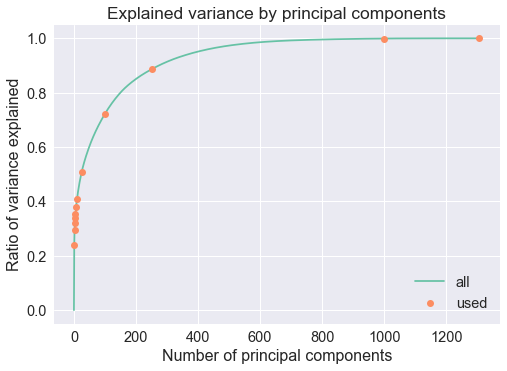

In [311]:
kvar = {}
for k in K_to_use:
    kvar[k] = sum(ipca50k.explained_variance_ratio_[:k])
kvar = pd.DataFrame(kvar,index=['explained variance']).T

fig = plt.figure()

plt.plot(np.cumsum(np.concatenate([[0], ipca50k.explained_variance_ratio_[:1308]])),label='all')
plt.plot(kvar,'o',label='used')
plt.title('Explained variance by principal components')
plt.xlabel('Number of principal components')
plt.ylabel('Ratio of variance explained')
plt.legend()

fig.savefig('../plots/explained_variance.png')
plt.show()

kvar.T